# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [67]:
import pandas as pd

df_1 = pd.read_csv("twitter_archive_enhanced.csv")

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [68]:
import requests

url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"

respuesta = requests.get(url)

with open('image_predictions.tsv', 'wb') as archivo:
    archivo.write(respuesta.content)

df_2 = pd.read_csv('image_predictions.tsv', sep='\t')

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [69]:
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_1.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()

# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)


with open('tweet_json.txt', 'r') as f:
    data = []
    for line in f:
        data.append(json.loads(line))

df_3 = pd.DataFrame(data)

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [70]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [71]:
df_1.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [72]:
df_1['name'].value_counts()

None            745
a                55
Charlie          12
Cooper           11
Oliver           11
Lucy             11
Lola             10
Penny            10
Tucker           10
Bo                9
Winston           9
Sadie             8
the               8
Buddy             7
Bailey            7
an                7
Toby              7
Daisy             7
Oscar             6
Jax               6
Stanley           6
Rusty             6
Dave              6
Bella             6
Koda              6
Scout             6
Leo               6
Jack              6
Milo              6
Bentley           5
               ... 
Brockly           1
Ember             1
Brownie           1
Hubertson         1
Ambrose           1
Rudy              1
Samsom            1
Maya              1
Geoff             1
Mona              1
by                1
Gerbald           1
Kane              1
Kial              1
Damon             1
Raphael           1
Clybe             1
Winifred          1
Ace               1


In [73]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [74]:
df_2.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [75]:
df_2['jpg_url'].nunique()

2009

In [76]:
df_2['p1'].value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
cocker_spaniel                30
malamute                      30
French_bulldog                26
Chesapeake_Bay_retriever      23
miniature_pinscher            23
seat_belt                     22
German_shepherd               20
Staffordshire_bullterrier     20
Siberian_husky                20
web_site                      19
Cardigan                      19
Eskimo_dog                    18
Maltese_dog                   18
Shetland_sheepdog             18
teddy                         18
beagle                        18
Rottweiler                    17
Shih-Tzu                      17
Lakeland_terrier              17
kuvasz                        16
Italian_greyhound             16
          

In [77]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
contributors                     0 non-null object
coordinates                      0 non-null object
created_at                       2354 non-null object
display_text_range               2354 non-null object
entities                         2354 non-null object
extended_entities                2073 non-null object
favorite_count                   2354 non-null int64
favorited                        2354 non-null bool
full_text                        2354 non-null object
geo                              0 non-null object
id                               2354 non-null int64
id_str                           2354 non-null object
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null object
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 non-null obj

In [78]:
df_3.head()

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
0,None,None,Tue Aug 01 16:23:56 +0000 2017,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,None,...,False,NaN,NaN,NaN,8853,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,None,None,Tue Aug 01 00:17:27 +0000 2017,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,None,...,False,NaN,NaN,NaN,6514,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,None,None,Mon Jul 31 00:18:03 +0000 2017,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",25461,False,This is Archie. He is a rare Norwegian Pouncin...,None,...,False,NaN,NaN,NaN,4328,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,None,None,Sun Jul 30 15:58:51 +0000 2017,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",42908,False,This is Darla. She commenced a snooze mid meal...,None,...,False,NaN,NaN,NaN,8964,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,None,None,Sat Jul 29 16:00:24 +0000 2017,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",41048,False,This is Franklin. He would like you to stop ca...,None,...,False,NaN,NaN,NaN,9774,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


### Quality issues
1.In all dataframes there are data with incorrect data types. For example we can miss some timestamps and strings.

2.In first dataset we can find some missing values in some fields like in in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp.

3.In first dataset there are some bad data like names of dogs. We can observe some dogs names like None, a or the.

4.The source column in first dataset contains html tags.

5.There are some columns with invalid data in the second dataframe, for example in p1 column we can see some raws with data like coral-reef, starfish, bookcase, etc.

6.The data of the second dataframe are very inconsistent. In p1, p2 and p3 we can see some data in lower case and other some data with the first letter in uppercase.

7.In the second dataframe there are some ratings with the same picture because there are some repeated jpg_url.

8.In the third dataframe there are some missing values in some columns.

### Tidiness issues
1.In the first dataframe we have four columns for dog stage instead a only one column with the current stage.

2.This three datasets are parts of the same dataset.

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [79]:
# Make copies of original pieces of data

df1_clean = df_1.copy()
df2_clean = df_2.copy()
df3_clean = df_3.copy()

### Issues
#### Define
- Merge the three copies of the dataframes.
- Merge the columns of dog stages in only one column.
- Delete duplicated data (retweets).
- Delete columns with irrelevant data.
- Change datatypes to the correct types.
- Correct name issues.


In [80]:
df3_clean.rename(columns={'id': 'tweet_id'}, inplace=True)
aux = pd.merge(df1_clean, df2_clean, on='tweet_id')
merged_df = pd.merge(aux, df3_clean, on='tweet_id')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 58 columns):
tweet_id                         2073 non-null int64
in_reply_to_status_id_x          23 non-null float64
in_reply_to_user_id_x            23 non-null float64
timestamp                        2073 non-null object
source_x                         2073 non-null object
text                             2073 non-null object
retweeted_status_id              79 non-null float64
retweeted_status_user_id         79 non-null float64
retweeted_status_timestamp       79 non-null object
expanded_urls                    2073 non-null object
rating_numerator                 2073 non-null int64
rating_denominator               2073 non-null int64
name                             2073 non-null object
doggo                            2073 non-null object
floofer                          2073 non-null object
pupper                           2073 non-null object
puppo                            2073 

In [81]:
merged_df['dog_stage'] = merged_df['text'].str.extract('(doggo|floofer|pupper|puppo)')
merged_df.head()

,tweet_id,in_reply_to_status_id_x,in_reply_to_user_id_x,timestamp,source_x,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source_y,truncated,user,dog_stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,NaN,NaN,NaN,8853,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,NaN,NaN,NaN,6514,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,NaN,NaN,NaN,4328,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,NaN,NaN,NaN,8964,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,NaN,NaN,NaN,9774,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN


In [82]:
merged_df = merged_df[(merged_df['rating_numerator']/merged_df['rating_denominator']) < 2]

In [83]:
merged_df = merged_df[merged_df['retweeted_status_id'].isna()]
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1988 entries, 0 to 2072
Data columns (total 59 columns):
tweet_id                         1988 non-null int64
in_reply_to_status_id_x          23 non-null float64
in_reply_to_user_id_x            23 non-null float64
timestamp                        1988 non-null object
source_x                         1988 non-null object
text                             1988 non-null object
retweeted_status_id              0 non-null float64
retweeted_status_user_id         0 non-null float64
retweeted_status_timestamp       0 non-null object
expanded_urls                    1988 non-null object
rating_numerator                 1988 non-null int64
rating_denominator               1988 non-null int64
name                             1988 non-null object
doggo                            1988 non-null object
floofer                          1988 non-null object
pupper                           1988 non-null object
puppo                            1988 non

In [84]:
merged_df = merged_df.drop(['quoted_status','quoted_status_id','quoted_status_id_str','retweeted_status','in_reply_to_screen_name','in_reply_to_status_id_y','in_reply_to_status_id_str','in_reply_to_user_id_y','in_reply_to_user_id_str','geo','coordinates','contributors','in_reply_to_status_id_x','in_reply_to_user_id_x','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp','place'],axis = 1)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1988 entries, 0 to 2072
Data columns (total 41 columns):
tweet_id                         1988 non-null int64
timestamp                        1988 non-null object
source_x                         1988 non-null object
text                             1988 non-null object
expanded_urls                    1988 non-null object
rating_numerator                 1988 non-null int64
rating_denominator               1988 non-null int64
name                             1988 non-null object
doggo                            1988 non-null object
floofer                          1988 non-null object
pupper                           1988 non-null object
puppo                            1988 non-null object
jpg_url                          1988 non-null object
img_num                          1988 non-null int64
p1                               1988 non-null object
p1_conf                          1988 non-null float64
p1_dog                          

In [92]:
merged_df['created_at'] = pd.to_datetime(merged_df['created_at'])
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])
merged_df.info()

,tweet_id,timestamp,source_x,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,is_quote_status,lang,possibly_sensitive,possibly_sensitive_appealable,retweet_count,retweeted,source_y,truncated,user,dog_stage
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,...,False,en,False,False,8853,False,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,...,False,en,False,False,6514,False,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,...,False,en,False,False,4328,False,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,...,False,en,False,False,8964,False,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,...,False,en,False,False,9774,False,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN


In [88]:
merged_df.loc[merged_df['name'] == 'a', 'name'] = None
merged_df['name'].value_counts().nlargest(10)

None       544
Charlie     11
Lucy        10
Cooper      10
Oliver      10
Tucker       9
Penny        9
Sadie        8
Winston      8
Daisy        7
Name: name, dtype: int64

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [88]:
merged_df.to_csv('twitter_archive_master.csv', index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

### Insights:
1.Top ten most posted dog breed.

2.Relation between favourites and retweet.

3.Relation between ratings and retweets.

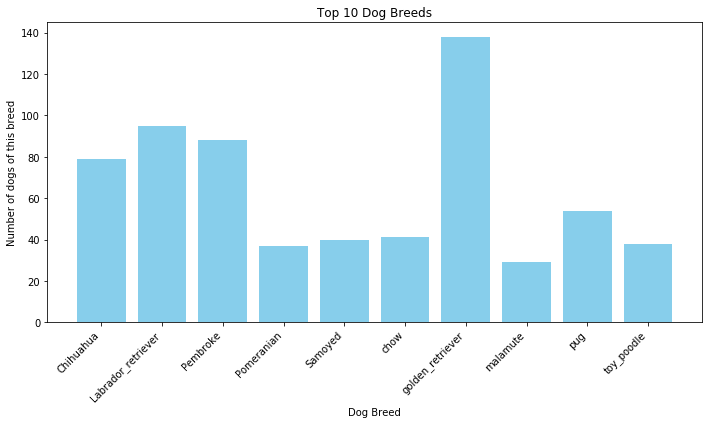

In [95]:
import matplotlib.pyplot as plt

p1 = merged_df['p1'].value_counts().nlargest(10)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(p1.index, p1.values, color='skyblue')
plt.xlabel('Dog Breed')
plt.ylabel('Number of dogs of this breed')
plt.title('Top 10 Dog Breeds')
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

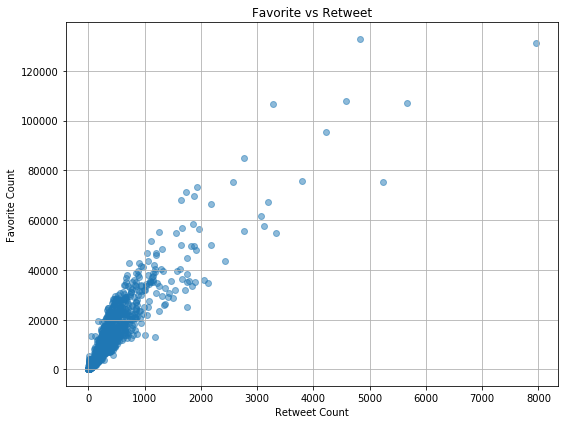

In [96]:
#retweets vs favorite count
plt.figure(figsize=(8, 6))
plt.scatter(merged_df['retweet_count']/merged_df['rating_denominator'], merged_df['favorite_count'], alpha=0.5);
plt.title('Favorite vs Retweet');
plt.xlabel('Retweet Count');
plt.ylabel('Favorite Count');
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()

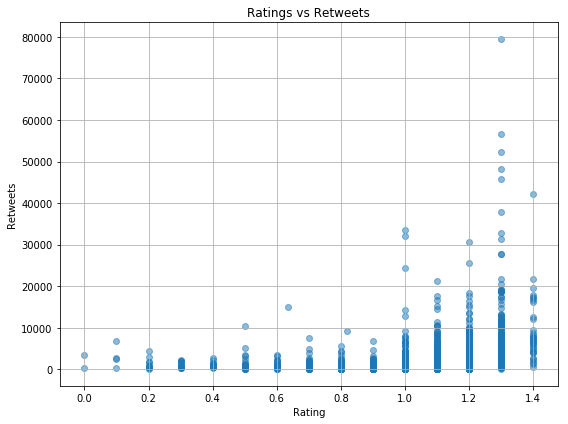

In [97]:
plt.figure(figsize=(8, 6))
plt.scatter((merged_df['rating_numerator']/merged_df['rating_denominator']), merged_df['retweet_count'], alpha=0.5)
plt.title('Ratings vs Retweets')
plt.xlabel('Rating')
plt.ylabel('Retweets')
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()

### Visualization

We’ll see the most popular dog names.

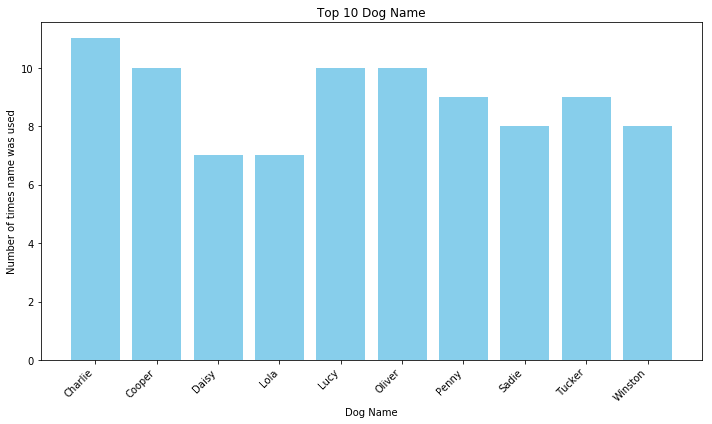

In [98]:
names_df = merged_df[merged_df['name'] != "None"]
names = names_df['name'].value_counts().nlargest(10)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(names.index, names.values, color='skyblue')
plt.xlabel('Dog Name')
plt.ylabel('Number of times name was used')
plt.title('Top 10 Dog Name')
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()